# Aligning Data across Modalities
With many forms of data, it can be highly useful to align multiple recording modalities together to identify how they relate to one-another or to interpret brain response activity. `Modalities` in most of files consist of behavioral data, like running speed and eye tracking recordings, as well as recordings from the brain. In this example, we use an *Ophys* file with the 2-Photon dF/F recording. This notebook shows these modalities, as well as the types of stimulus presented, aligned in time to provide insight.

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi_utils import dandi_download_open
from scipy import interpolate

%matplotlib inline

### Downloading NWB File
Change the values below to download the file you’re interested in. In this example, we the `Units` table of an Ecephys file from The Allen Institute's **Dendritic Coupling** dataset, which is currently embargoed, so you'll have to choose one with the same kind of data. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000336"
dandi_filepath = "sub-621602/sub-621602_ses-1193555033-acq-1193675753_ophys.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
# This can sometimes take a while depending on the size of the file
nwb = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)

File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Getting Running Speed, Eye Tracking, and Fluorescence Data
Since this notebook is meant for Ophys data, it will include the fluorescence recordings from ROIs. But it will also include the behavioral measurments. The important arrays to extract here are `running_speed_trace`, `eye_tracking_area`, `blink_times`, and `dff_trace`. Their associated timestamps are also needed so these arrays can each be interpolated to the same aligned timescale.

In [5]:
running_speed = nwb.processing["running"]["speed"]
running_speed_trace = running_speed.data
running_speed_timestamps = running_speed.timestamps

In [6]:
eye_tracking = nwb.acquisition["EyeTracking"].eye_tracking
# eye_tracking = nwb.acquisition["EyeTracking"].corneal_reflection_tracking
# eye_tracking = nwb.acquisition["EyeTracking"].pupil_tracking
eye_tracking_area = eye_tracking.area
eye_tracking_timestamps = eye_tracking.timestamps

blink_times = nwb.acquisition["EyeTracking"].likely_blink

In [7]:
dff = nwb.processing["ophys"]["dff"].roi_response_series["traces"]
dff_trace = dff.data
dff_timestamps = dff.timestamps

### Getting Stimulus Epochs
In addition to the data mentioned above, the stimulus presentations can also be shown alongside the time-aligned modalities. This could help to identify what responses are evoked by what stimuli. 

Here, *epochs* are extracted from all the stimulus tables in the `Intervals` section. In this case, an epoch is a continuous period of time during a session where a particular type of stimulus is shown. The output here is a list of epochs, where an epoch is a tuple of four values; the stimulus name, the stimulus block, the starting time and the ending time. Since stimulus information can vary signifcantly between experiments and NWB files, you may need to tailor the code below to extract epochs for the file you're interested in. For more information on the stimulus tables, see [Visualizing 2P Responses to Stimulus](../visualization/visualize_2p_responses.ipynb).

In [8]:
### extract epoch times from stim table where stimulus rows have a different 'block' than following row
### returns list of epochs, where an epoch is of the form (stimulus name, stimulus block, start time, stop time)
def extract_epochs(stim_name, stim_table, epochs):
    
    # specify a current epoch stop and start time
    epoch_start = stim_table.start_time[0]
    epoch_stop = stim_table.stop_time[0]

    # for each row, try to extend current epoch stop_time
    for i in range(len(stim_table)):
        this_block = stim_table.stimulus_block[i]
        # if end of table, end the current epoch
        if i+1 >= len(stim_table):
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            break
            
        next_block = stim_table.stimulus_block[i+1]
        # if next row is the same stim block, push back epoch_stop time
        if next_block == this_block:
            epoch_stop = stim_table.stop_time[i+1]
        # otherwise, end the current epoch, start new epoch
        else:
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            epoch_start = stim_table.start_time[i+1]
            epoch_stop = stim_table.stop_time[i+1]
    
    return epochs

In [9]:
# extract epochs from all valid stimulus tables
epochs = []
for stim_name in nwb.intervals.keys():
    stim_table = nwb.intervals[stim_name]
    try:
        epochs = extract_epochs(stim_name, stim_table, epochs)
    except:
        continue

# epochs take the form (stimulus name, stimulus block, start time, stop time)
print(len(epochs))
epochs.sort(key=lambda x: x[2])
for epoch in epochs:
    print(epoch)

185
('movie_worms_fwd_presentations', 0.0, 30.024739999999998, 39.03206548402213)
('movie_touch_of_evil_fwd_presentations', 1.0, 40.03292999999999, 49.04037548402212)
('movie_touch_of_evil_fwd_presentations', 2.0, 50.04123, 59.04856548402212)
('movie_worms_fwd_presentations', 3.0, 60.04946, 69.05684548402212)
('movie_flower_fwd_presentations', 4.0, 70.05771, 79.06509548402214)
('movie_worms_fwd_presentations', 5.0, 80.06594, 89.07333548402214)
('movie_touch_of_evil_fwd_presentations', 6.0, 90.0742, 99.08157548402214)
('movie_flower_fwd_presentations', 7.0, 100.08243, 109.08985548402212)
('movie_flower_fwd_presentations', 8.0, 110.09074, 119.09813548402214)
('movie_flower_fwd_presentations', 9.0, 120.09896, 129.10637548402212)
('movie_touch_of_evil_fwd_presentations', 10.0, 130.10725, 139.11459548402212)
('movie_worms_fwd_presentations', 11.0, 140.11548, 149.12289548402214)
('movie_worms_fwd_presentations', 12.0, 150.12377999999998, 159.13115548402212)
('movie_flower_fwd_presentations',

### Interpolation
Finally before plotting, in order to align these modalities, they must be interpolated to the same hertz and timescale. Set `start_time` and `end_time` to the bounds of the period you're interested in seeing. That section of the data will be aligned and displayed together. `interp_hz` can also be adjusted if necessary to change the Hertz that the data are interpolated to.

In [10]:
start_time = 1500
end_time = 2000
interp_hz = 100

In [11]:
time_axis = np.arange(start_time, end_time, step=1/interp_hz)

f1 = interpolate.interp1d(running_speed_timestamps, running_speed_trace, axis=0, kind="nearest", fill_value="extrapolate")
interp_running_speed = f1(time_axis)

f2 = interpolate.interp1d(eye_tracking_timestamps, eye_tracking_area, axis=0, kind="nearest", fill_value="extrapolate")
interp_eye_area = f2(time_axis)

f3 = interpolate.interp1d(dff_timestamps, dff_trace, axis=0, kind="nearest", fill_value="extrapolate")
interp_dff = f3(time_axis) * 100 # to yield dF/F %
interp_dff = np.array(interp_dff).transpose() # transpose to make time axis secondary

In [12]:
# get blink times that occur between start_time and end_time
start_idx, end_idx = np.searchsorted(blink_times.timestamps, [start_time, end_time])
blink_idxs = np.where(blink_times.data[start_idx:end_idx])[0] # where blink time value is 'True'
interval_blink_times = blink_times.timestamps[start_idx:end_idx][blink_idxs]

### Displaying Aligned Modalities
Below we defined the method `show_epochs` which displays the blocks of time that the epochs occupy. Lastly, each modality is displayed on their own subplots and all share the x-axis. 

In [13]:
### on given axis, take each epoch and draw it as a uniquely colored rectangle
### returns dict of colors mapped to epochs
def show_epochs(ax, epochs):
    # make unique color for each stim name
    stim_names = list({epoch[0] for epoch in epochs})
    colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
    stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

    epoch_key = {}
    # draw colored rectangles for each epoch
    for epoch in epochs:
        stim_name, stim_block, epoch_start, epoch_end = epoch
        if epoch_end < time_axis[0] or epoch_start > time_axis[-1]:
            continue

        color = stim_color_map[stim_name]
        rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, 0), epoch_end-epoch_start, 1, alpha=0.2, facecolor=color))
        epoch_key[stim_name] = rec

    ax.set_yticks([])
    return epoch_key

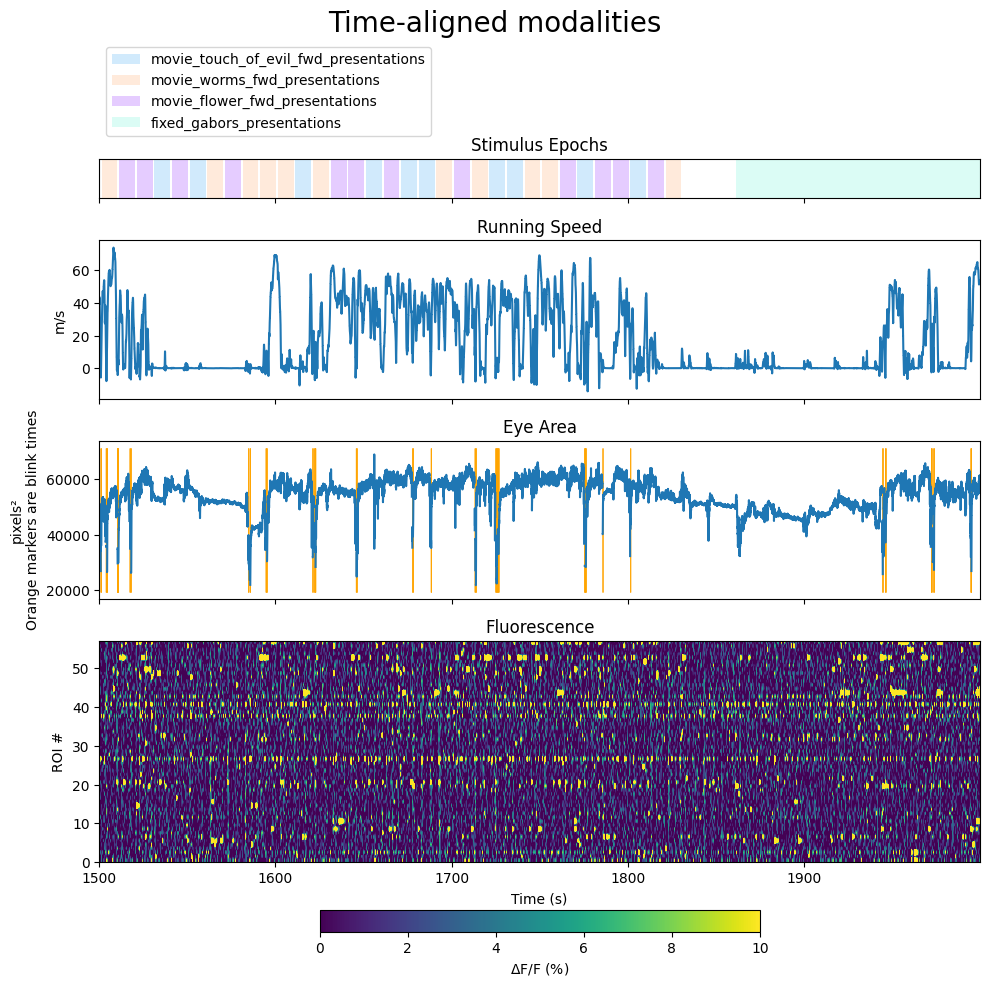

In [14]:

gridspec_dict = {"height_ratios":[0.5,2,2,4]}
fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True, gridspec_kw=gridspec_dict)

# epochs plot with legend
epoch_key = show_epochs(axes[0], epochs)
axes[0].set_xlim(time_axis[0], time_axis[-1])
axes[0].set_title("Stimulus Epochs")
legend_offset = max(2, len(epoch_key))
axes[0].legend(epoch_key.values(), epoch_key.keys(), loc="upper left", bbox_to_anchor=(0,legend_offset))

# running speed modality
axes[1].plot(time_axis, interp_running_speed)
axes[1].set_ylabel("m/s")
axes[1].set_title("Running Speed")

# eye area modality with blink times marked
axes[2].plot(time_axis, interp_eye_area)
axes[2].set_ylabel("pixels²\nOrange markers are blink times")
ymin, ymax = axes[2].get_ylim()
axes[2].vlines(x=interval_blink_times, ymin=ymin, ymax=ymax, color="orange", lw=0.5, alpha=0.25, zorder=0)
axes[2].set_title("Eye Area")

# fluorescence modality
im = axes[3].imshow(interp_dff, extent=[start_time, end_time, 0, interp_dff.shape[0]], aspect="auto", vmin=0, vmax=10)
axes[3].set_ylabel("ROI #")
axes[3].set_xlabel("Time (s)")
axes[3].set_title("Fluorescence")
fig.colorbar(im, label="$\Delta$F/F (%)", orientation="horizontal", shrink=0.5)

fig.suptitle("Time-aligned modalities", fontsize=20)
plt.tight_layout()
plt.show()